# 04 - Model Evaluation and Kaggle Submission

This notebook evaluates our best-performing model on the held-out validation set and generates predictions for the Kaggle competition submission.

## 1. Imports and Data Loading

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [38]:
X_val = np.load('../data/processed/X_val.npy')
y_val = np.load('../data/processed/y_val.npy')
X_test = np.load('../data/processed/X_test.npy')
test_indices = np.load('../data/processed/test_indices.npy')

print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Validation set: (20000, 20)
Test set: (100000, 20)


## 2. Load Best Model

In [39]:
with open('../models/best_model.txt', 'r') as f:
    best_model_name = f.read().strip()

print(f"Best model: {best_model_name}")

model_paths = {
    'Random Forest': '../models/random_forest.pkl',
    'XGBoost': '../models/xgboost.pkl',
    'Neural Network': '../models/neural_network.keras'
}

model_path = model_paths[best_model_name]

if best_model_name == 'Neural Network':
    model = keras.models.load_model(model_path)
    if model is None:
        raise ValueError(f"Failed to load model from {model_path}")
else:
    model = joblib.load(model_path)

print(f"Loaded from: {model_path}")

Best model: XGBoost
Loaded from: ../models/xgboost.pkl


## 3. Validation Set Evaluation

In [40]:
if best_model_name == 'Neural Network':
    y_pred = model.predict(X_val, verbose=0).flatten()
else:
    y_pred = model.predict(X_val)

print(f"Predictions generated for {len(y_pred)} samples")

Predictions generated for 20000 samples


In [41]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100

print(f"FINAL MODEL EVALUATION: {best_model_name}")
print("=" * 50)
print(f"RMSE: {rmse:,.2f}")
print(f"MAE:  {mae:,.2f}")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print("=" * 50)

FINAL MODEL EVALUATION: XGBoost
RMSE: 497,846.55
MAE:  257,570.89
R²:   0.9924
MAPE: 1.51%


## 4. Prediction Analysis

We compare predicted prices against actual prices and examine the residuals to assess model fit.

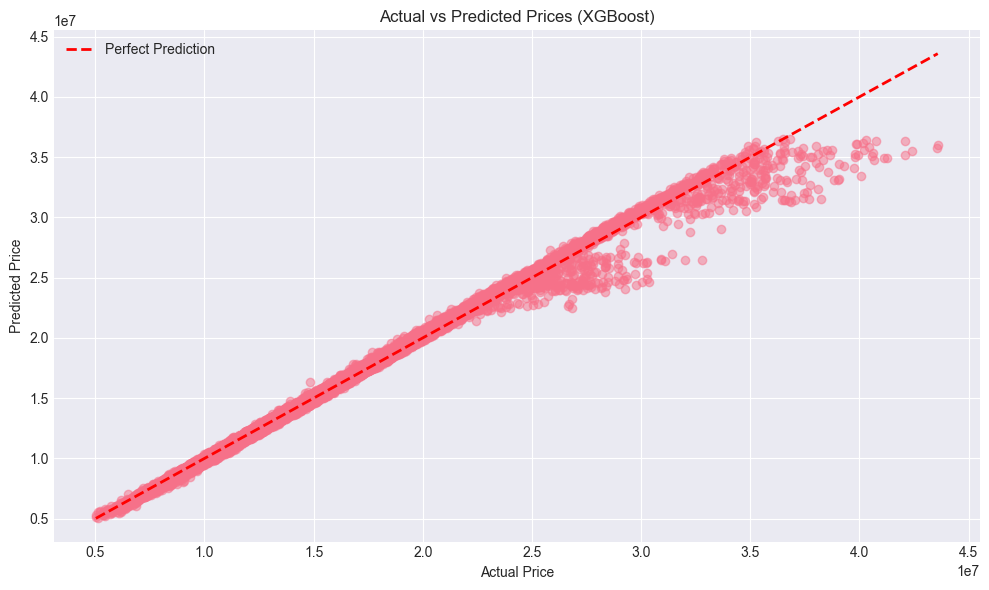

In [42]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Actual vs Predicted Prices ({best_model_name})')
plt.legend()
plt.tight_layout()
plt.show()

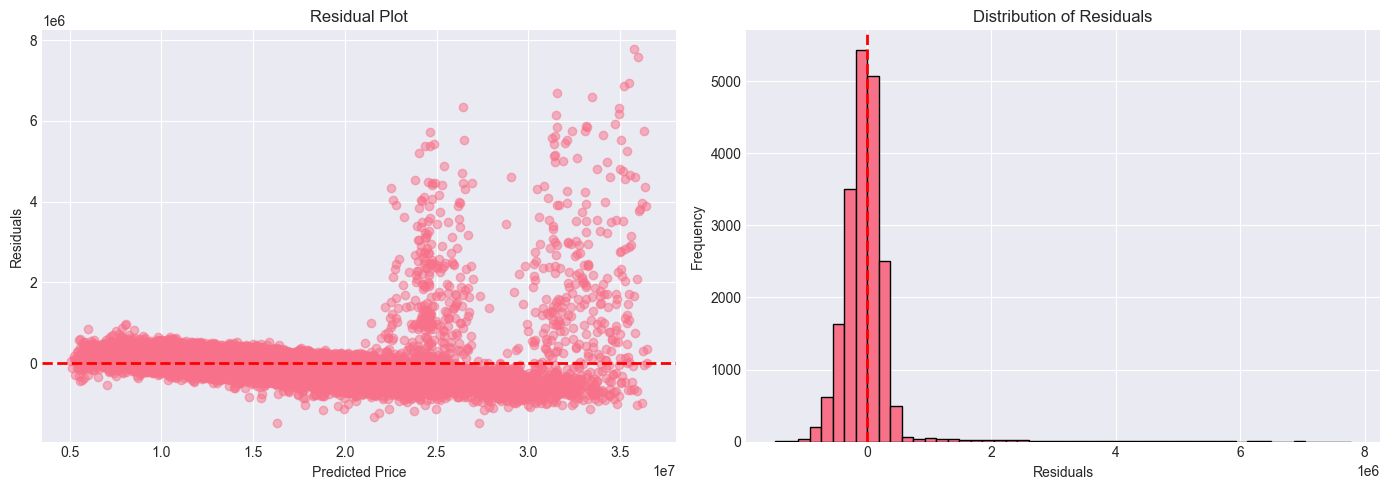

In [43]:
residuals = y_val - y_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_pred, residuals, alpha=0.5)
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Price')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residual Plot')

axes[1].hist(residuals, bins=50, edgecolor='black')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Residuals')
axes[1].axvline(x=0, color='r', linestyle='--', lw=2)

plt.tight_layout()
plt.show()

In [44]:
print("Residual Statistics:")
print(f"  Mean: {residuals.mean():,.2f}")
print(f"  Std:  {residuals.std():,.2f}")
print(f"  Min:  {residuals.min():,.2f}")
print(f"  Max:  {residuals.max():,.2f}")

Residual Statistics:
  Mean: -15,178.07
  Std:  497,615.10
  Min:  -1,477,710.00
  Max:  7,781,366.00


## 5. Feature Importance

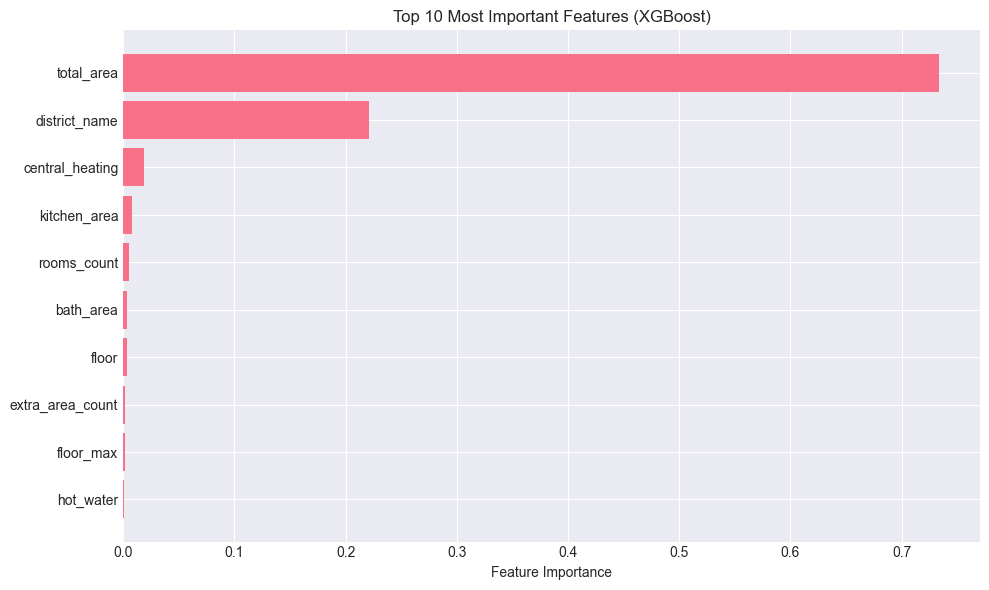


Top 5 Features:
  1. total_area: 0.7337
  2. district_name: 0.2208
  3. central_heating: 0.0186
  4. kitchen_area: 0.0077
  5. rooms_count: 0.0052


In [45]:
if best_model_name in ['Random Forest', 'XGBoost']:
    feature_names = open('../data/processed/feature_names.txt').read().split('\n')
    importances = model.feature_importances_

    indices = np.argsort(importances)[::-1][:10]

    plt.figure(figsize=(10, 6))
    plt.barh(range(10), importances[indices])
    plt.yticks(range(10), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 10 Most Important Features ({best_model_name})')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("\nTop 5 Features:")
    for i in range(5):
        print(f"  {i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")
else:
    print(f"Feature importance not directly available for {best_model_name}.")

## 6. Test Set Predictions

In [46]:
if best_model_name == 'Neural Network':
    test_predictions = model.predict(X_test, verbose=0).flatten()
else:
    test_predictions = model.predict(X_test)

test_predictions = np.maximum(test_predictions, 0)

print(f"Generated {len(test_predictions)} predictions")
print(f"\nPrediction statistics:")
print(f"  Min:    {test_predictions.min():,.2f}")
print(f"  Max:    {test_predictions.max():,.2f}")
print(f"  Mean:   {test_predictions.mean():,.2f}")
print(f"  Median: {np.median(test_predictions):,.2f}")

Generated 100000 predictions

Prediction statistics:
  Min:    4,951,596.50
  Max:    37,028,352.00
  Mean:   15,998,747.00
  Median: 14,905,116.00


## 7. Kaggle Submission

In [47]:
submission = pd.DataFrame({
    'index': test_indices,
    'price': test_predictions
})

print("Submission preview:")
print(submission.head(10))
print(f"\nShape: {submission.shape}")

Submission preview:
   index       price
0      0  18304872.0
1      1  15868292.0
2      2  12279730.0
3      3   9860789.0
4      4   9530421.0
5      5  34611908.0
6      6  18745052.0
7      7  20052882.0
8      8  22844200.0
9      9  16935956.0

Shape: (100000, 2)


In [48]:
submission_path = '../submissions/final_submission.csv'
submission.to_csv(submission_path, index=False)

print(f"Submission file saved to: {submission_path}")

Submission file saved to: ../submissions/final_submission.csv
